# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

Using TensorFlow backend.


### Change directory

In [0]:
import os
os.chdir('/content/drive/My Drive/AIML PG/R9_Internal_lab/R9_Internal_lab/images')

### Load the training data from train.csv file

In [0]:
import pandas as pd
train_data = pd.read_csv('/content/drive/My Drive/AIML PG/R9_Internal_lab/R9_Internal_lab/train_labels.csv')

### Print the shape of the train dataset

In [8]:
train_data.shape

(173, 8)

In [14]:
train_data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
with open('/content/drive/My Drive/AIML PG/R9_Internal_lab/R9_Internal_lab/train_labels.csv','r') as csv_file:
  paths = []
  coords = np.zeros((sum(1 for line in csv_file)-1, 4))
  reader = csv.reader(csv_file, delimiter=',')
  csv_file.seek(0)
  next(reader)
  for col, row in enumerate(reader):
    path, image_width,image_height,_, x0, y0, x1, y1 = row  
    path = '/content/drive/My Drive/AIML PG/R9_Internal_lab/R9_Internal_lab/images/'+path
    coords[col, 0] = int(x0) * IMAGE_SIZE / int(image_width) # Normalize bounding box by image size
    coords[col, 1] = int(y0) * IMAGE_SIZE / int(image_height) # Normalize bounding box by image size
    coords[col, 2] = (int(x1) - int(x0)) * IMAGE_SIZE / int(image_width) # Normalize bounding box by image size
    coords[col, 3] = (int(y1) - int(y0)) * IMAGE_SIZE / int(image_height)
    paths.append(path)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [72]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)












17227776/17225924 [==============================] - 0s 0us/step


### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [75]:
model.compile(optimizer='Adam',loss='mse',metrics=[IoU])
model.fit(x=batch_images,y=coords,batch_size=32,epochs=30,verbose=1)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


Epoch 1/30
173/173 [==============================] - 6s 35ms/step - loss: 2853.5638 - IoU: 0.0807
Epoch 2/30
173/173 [==============================] - 5s 29ms/step - loss: 655.8099 - IoU: 0.4279
Epoch 3/30
173/173 [==============================] - 5s 30ms/step - loss: 663.5631 - IoU: 0.5405
Epoch 4/30
173/173 [==========

### Pick a test image from the given data

In [0]:
import cv2
filename = '/content/drive/My Drive/AIML PG/R9_Internal_lab/R9_Internal_lab/images/raccoon-115.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

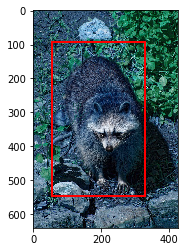

In [81]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change your present working directory

In [0]:
import os
os.chdir('/content/drive/My Drive/AIML PG/R9_Internal_lab/R9_Internal_lab')

### Load your data file

In [0]:
train_data = pd.read_csv('daily-minimum-temperatures-in-me.csv')

#### Plot data

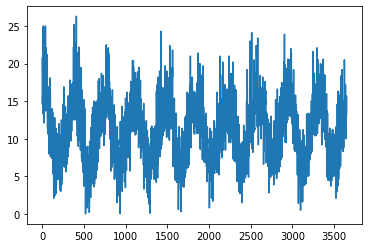

In [90]:
plt.plot(train_data['Temperature'])

#### Descibe your dataframe

In [91]:
train_data.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [93]:
train_data[train_data.Temperature.isnull()]

,Date,Temperature


In [94]:
train_data[train_data.Date.isnull()]

,Date,Temperature


#### Drop null values

In [0]:
train_data.dropna(axis=0,inplace=True)

#### Get the representation of the distribution of data in the form of histogram

(array([ 234., 1426., 1500.,  449.,   41.]),
 array([ 0.  ,  5.26, 10.52, 15.78, 21.04, 26.3 ]),
 <a list of 5 Patch objects>)

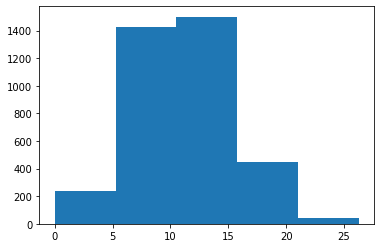

In [98]:
plt.hist(x=train_data['Temperature'],bins=5)

#### Check the maximum and minimum values

In [100]:
print('Minimum {} Maximum {}'.format(train_data.Temperature.min(),train_data.Temperature.max()))

Minimum 0.0 Maximum 26.3


### Normalize the data

In [0]:
train_data.drop("Date", axis=1, inplace=True)

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_data)

#### Check the maximum and minimum values of scaled data

In [106]:
print('min {} max {}'.format(scaled.min(),scaled.max()))

min 0.0 max 1.0


#### Look into some of the scaled values

In [107]:
scaled

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       ...,
       [0.51330798],
       [0.59695817],
       [0.49429658]])

### Split data into Training and Testing

In [0]:
#70% examples will used for training (in the begining)
train_size = int(len(scaled) * 0.70)

#30% will be used for Test
test_size = len(scaled - train_size)

#### Print train and test size

In [109]:
#Split the data
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
#window - how long the sequence will be
def create_dataset(dataset, window=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-window):
        
        a = dataset[i:(i+window), 0]        
        dataX.append(a)
        dataY.append(dataset[i + window, 0])
    
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [0]:
#Create Input and Output
window_size = 1
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [122]:
X_train.shape

(2554, 1, 1)

## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
tf.keras.backend.clear_session()
LSTMcheckpoint_path = "lstm.ckpt"
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape=(1, X_test.shape[1])))
model.add(tf.keras.layers.Dense(1))
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=LSTMcheckpoint_path,
                                                 save_weights_only=True,
                                                 monitor='loss',
                                                 mode = 'min',
                                                 save_best_only=True,
                                                 verbose=1)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

### Summarize your model

In [126]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [128]:
model.fit(x=X_train,y=y_train,batch_size=32,epochs=100,callbacks=[cp_callback],validation_data=(X_test,y_test))

Train on 2554 samples, validate on 1094 samples
Epoch 1/100
2144/2554 [========================>.....] - ETA: 0s - loss: 0.1083 - mean_squared_error: 0.1083
Epoch 00001: loss improved from inf to 0.09632, saving model to lstm.ckpt
2554/2554 [==============================] - 1s 392us/sample - loss: 0.0963 - mean_squared_error: 0.0963 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 2/100
2080/2554 [=======================>......] - ETA: 0s - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 00002: loss improved from 0.09632 to 0.01693, saving model to lstm.ckpt
2554/2554 [==============================] - 0s 145us/sample - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 3/100
2112/2554 [=======================>......] - ETA: 0s - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 00003: loss improved from 0.01693 to 0.01396, saving model to lstm.ckpt
2554/2554 [==============================] - 0s 137us/sample - loss: 0.0140 - mea

## Make Predictions and Evaluate your model

In [0]:
#Get prediction for both Training and Test Data
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [130]:
myInput = np.reshape(scaler.transform(pd.DataFrame({"Temperature":[19]})), 1,1)
int(scaler.inverse_transform(model.predict(np.reshape(myInput, (1, 1, 1)))))

16

## Plot the results

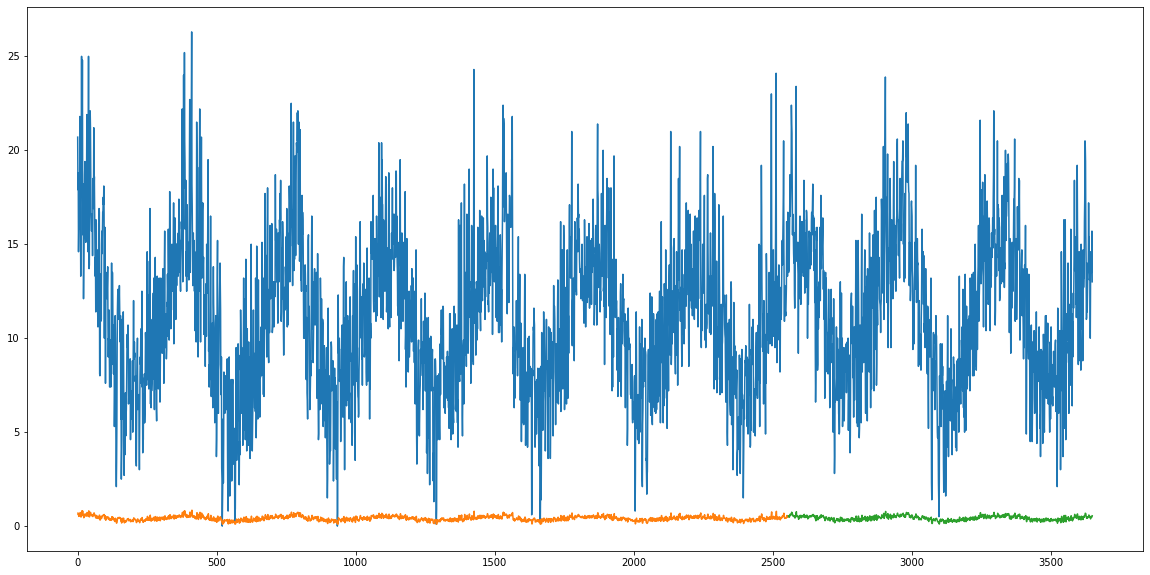

In [131]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()